In [2]:
import matplotlib.pyplot as plt
import numba
import numpy as np
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, DBSCAN
from gudhi.clustering.tomato import Tomato
import umap
import torch
import plotly.graph_objects as go
from utils import plot_diagrams
from collections import Counter
from circular_cords import get_coords
from random import seed

In [3]:
seed(168)
np.random.seed(46)

Import the data. "activity" is then a 40000xneurons matrix with all activations.

In [4]:
activity = np.load("activations/ILSVRC2015/inception4e.npy")
print(activity.shape)
neurons = activity.shape[1]

(50761, 832)


Use UMap to project to 2D

In [5]:
# Fixing umap bug. https://github.com/lmcinnes/pynndescent/issues/163


@numba.njit(fastmath=True)
def correct_alternative_cosine(ds):
    result = np.empty_like(ds)
    for i in range(ds.shape[0]):
        result[i] = 1.0 - np.power(2.0, ds[i])
    return result


import pynndescent

pynn_dist_fns_fda = pynndescent.distances.fast_distance_alternatives
pynn_dist_fns_fda["cosine"]["correction"] = correct_alternative_cosine
pynn_dist_fns_fda["dot"]["correction"] = correct_alternative_cosine

In [6]:
layout_2d = umap.UMAP(
    n_components=2, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(activity)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_neighbors=20, verbose=True)
Tue Feb 15 23:29:02 2022 Construct fuzzy simplicial set
Tue Feb 15 23:29:02 2022 Finding Nearest Neighbors
Tue Feb 15 23:29:02 2022 Building RP forest with 16 trees
Tue Feb 15 23:29:03 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Tue Feb 15 23:29:13 2022 Finished Nearest Neighbor Search
Tue Feb 15 23:29:14 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Feb 15 23:29:35 2022 Finished embedding


In [7]:
layout = umap.UMAP(
    n_components=neurons, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(activity)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=832, n_neighbors=20, verbose=True)
Tue Feb 15 23:29:35 2022 Construct fuzzy simplicial set
Tue Feb 15 23:29:35 2022 Finding Nearest Neighbors
Tue Feb 15 23:29:35 2022 Building RP forest with 16 trees
Tue Feb 15 23:29:36 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Tue Feb 15 23:29:39 2022 Finished Nearest Neighbor Search
Tue Feb 15 23:29:40 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Feb 15 23:43:15 2022 Finished embedding


Cluster the UMap output with kMeans to get 10 cluster. Then visualize.

In [26]:
kmeans = KMeans(9, random_state=42)
clusters = kmeans.fit_predict(layout)
# clusters=kmeans.fit_predict(activity)

/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/gudhi/point_cloud/dtm.py:168: RuntimeWarning: divide by zero encountered in reciprocal
  density = dtm ** (-dim / q)
/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/gudhi/point_cloud/dtm.py:168: RuntimeWarning: overflow encountered in reciprocal
  density = dtm ** (-dim / q)


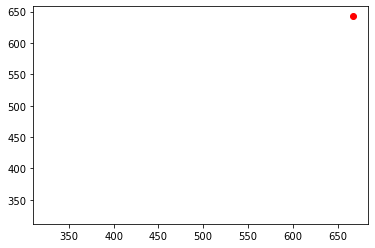

In [8]:
t = Tomato(density_type="logDTM", k=200)  # logDTM, DTM, ‘KDE’ or ‘logKDE’
clusters = t.fit_predict(layout)
t.plot_diagram()

In [9]:
print(t.n_clusters_)
print(Counter(t.labels_).most_common(10))
clusters = t.labels_

173
[(116, 1499), (32, 1058), (19, 983), (21, 904), (48, 749), (11, 730), (30, 701), (50, 700), (80, 690), (35, 671)]


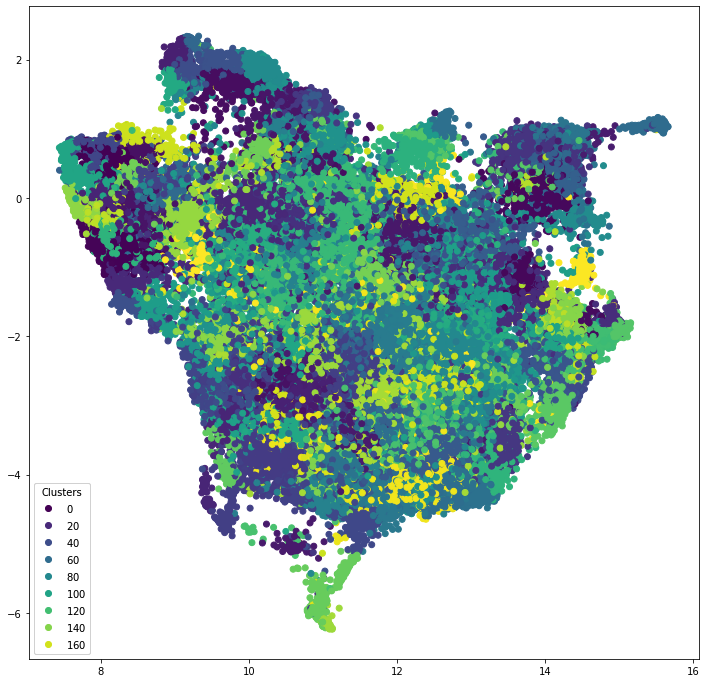

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(x=layout_2d[:, 0], y=layout_2d[:, 1], c=clusters)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

In cluster 7 there is a circle in the activations. To see it we apply UMAp as a prepocessing step. Then it's visible with persistent homology. 

In [11]:
cluster = []
for n in range(len(clusters)):
    if clusters[n] in [116]:
        cluster.append(activity[n])
cluster = np.array(cluster)
print(cluster.shape)

(1499, 832)


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=832, n_neighbors=20, verbose=True)
Tue Feb 15 23:49:32 2022 Construct fuzzy simplicial set
Tue Feb 15 23:49:33 2022 Finding Nearest Neighbors
Tue Feb 15 23:49:34 2022 Finished Nearest Neighbor Search
Tue Feb 15 23:49:34 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Feb 15 23:49:46 2022 Finished embedding


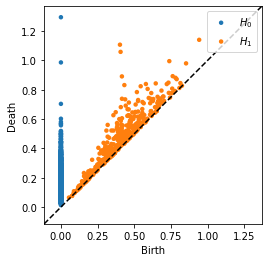

<AxesSubplot:xlabel='Birth', ylabel='Death'>

In [12]:
layout2 = umap.UMAP(
    n_components=neurons, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)
M = squareform(pdist(layout2, "euclidean"))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)

fig, ax = plt.subplots()
plot_diagrams(persistence["dgms"], plot_only=np.arange(maxdim + 1), ax=ax, show=True)

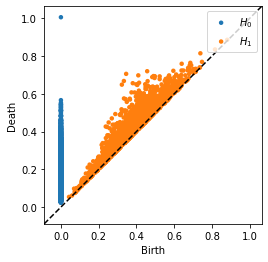

In [30]:
fig, ax = plt.subplots()
plot_diagrams(persistence["dgms"], plot_only=np.arange(maxdim + 1), ax=ax, show=True)

In [41]:
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1

iMax = np.argsort(lives1)
print(f"Longest bar: {lives1.max()} at index {iMax[-1]}.")
print(births1[iMax[-1]])
print(deaths1[iMax[-1]])
print(lives1[iMax[-5:]])
threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)
print(f"{threshold=}")

cocycle = cocycles[iMax[-1]]
print(f"{cocycle=}")
print(f"{cocycle.shape=}")
print(Counter(cocycle[:, 2]).most_common(10))

Longest bar: 0.3600587844848633 at index 1109.
0.34534674882888794
0.7054055333137512
[0.27554628 0.28781012 0.32557318 0.33425114 0.36005878]
threshold=0.669399654865265
cocycle=array([[2355, 1275,    1],
       [3266, 1425,    1],
       [2816,  818,   46],
       ...,
       [ 899,  633,    1],
       [2516,  118,    1],
       [1974,  891,    1]])
cocycle.shape=(3099, 3)
[(1, 1706), (46, 1393)]


Use the code to compute a circular parameter for the identified circle using circular parametrization (de Silva):

In [13]:
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)

cocycle = cocycles[iMax[-1]]

f, theta_matrix, verts, num_verts = get_coords(
    cocycle=cocycle,
    threshold=threshold,
    num_sampled=len(layout2),
    dists=M,
    coeff=coeff,
    bool_smooth_circle="perea",  # "graph", "old"
    weights=[],
)

print(len(f))

number of vertices = 1499
number of edges = 96417
1499


Visualize it after projecting to 3d: 

In [14]:
layout_3d = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d[:, 0],
            y=layout_3d[:, 1],
            z=layout_3d[:, 2],
            mode="markers",
            marker=dict(
                size=12, color=f, colorscale="Viridis", opacity=0.8, showscale=True
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D.html")
fig.show()

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Tue Feb 15 23:50:23 2022 Construct fuzzy simplicial set
Tue Feb 15 23:50:25 2022 Finding Nearest Neighbors
Tue Feb 15 23:50:25 2022 Finished Nearest Neighbor Search
Tue Feb 15 23:50:25 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Feb 15 23:50:26 2022 Finished embedding


Not all neurons contribute equally to this circle. We identify the ones that tune to it: 

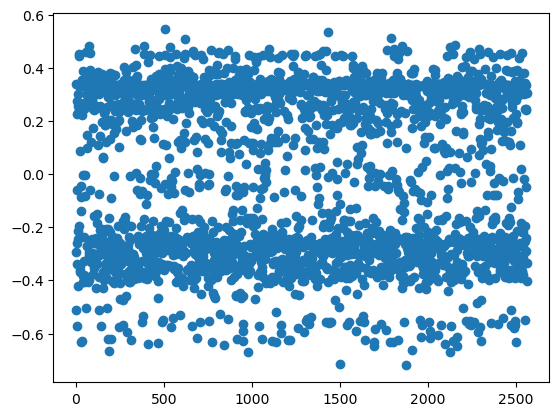

In [20]:
plt.scatter(y=f, x=verts)
plt.show()

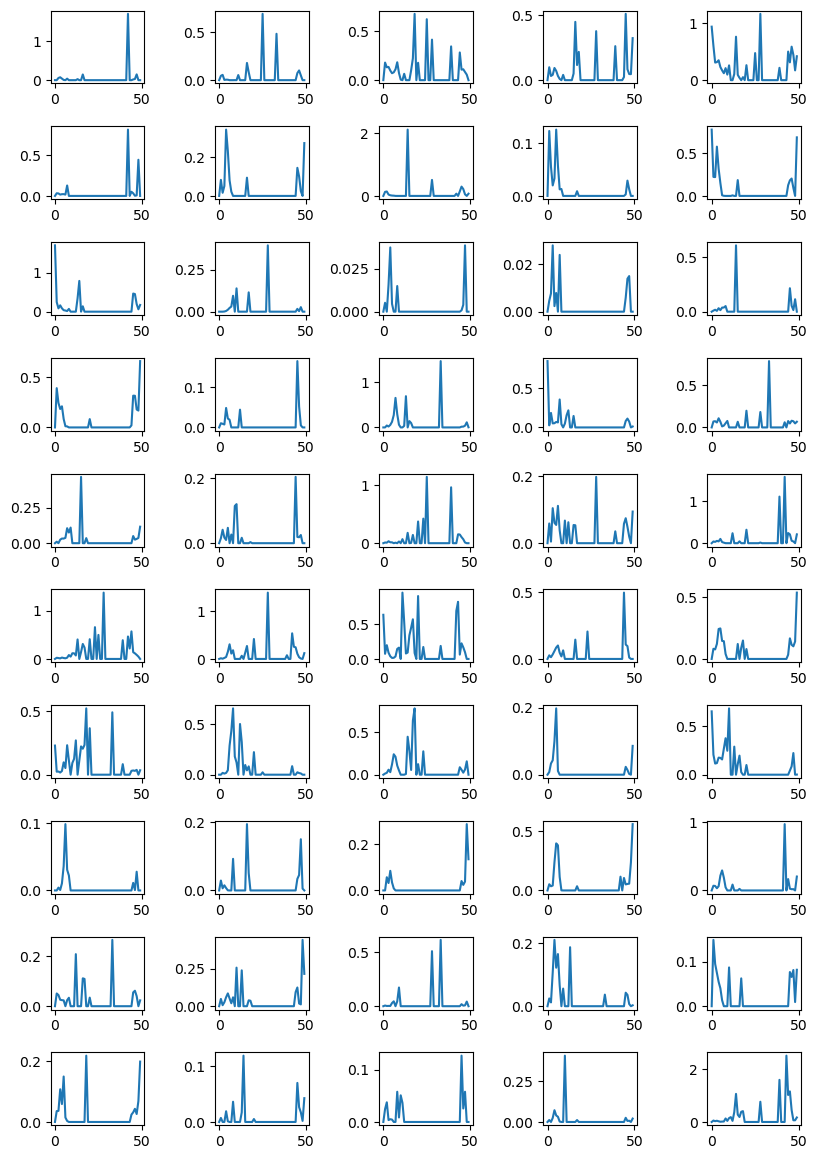

In [15]:
circ_rates = np.zeros([neurons, 50])
bins = np.linspace(f.min(), f.max(), 51)
for b in range(len(bins) - 1):
    for n in range(neurons):
        rates = []
        for x in range(len(cluster)):
            if bins[b] < f[x] <= bins[b + 1]:
                rates.append(cluster[x, n])
        if rates:
            circ_rates[n, b] = np.mean(rates)
        else:
            circ_rates[n, b] = 0

fig, axs = plt.subplots(10, 5, figsize=(8.27, 11.69))
for n in range(5):
    for m in range(10):
        axs[m, n].plot(range(50), circ_rates[m * 5 + n])
fig.tight_layout()

To quantify this we compute the information rate of the neurons:

/var/folders/dv/2b73qfmn5rv5r60s5j4vz8dr0000gn/T/ipykernel_98128/3293569943.py:5: RuntimeWarning:

invalid value encountered in true_divide



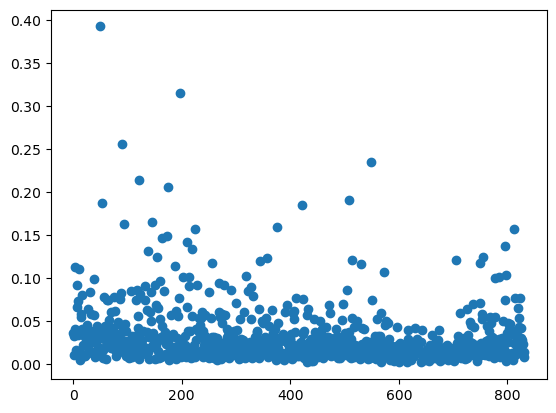

In [16]:
def inform_rate(mean_n, data, coun):
    m = []
    for b in range(50):
        m.append(data[b])
    return np.sum(m * np.log2((m / mean_n) + 0.0000001) * coun)


mean = np.zeros(neurons)
for n in range(neurons):
    mean[n] = np.mean(cluster[:, n])

counts = []
for b in range(len(bins) - 1):
    count = 0
    for p in f:
        if bins[b] < p < bins[b + 1]:
            count += 1
    counts.append(count / len(f))

inform_rates = []
for n in range(neurons):
    inform_rates.append(inform_rate(mean[n], circ_rates[n, :], counts))

plt.scatter(range(len(inform_rates)), inform_rates)
plt.show()

Then we pick the ones with an information rate higher then 0.2:

In [25]:
inform = 0.1
high_inform = np.where(np.array(inform_rates) > inform)[0]
print(high_inform)
len(high_inform)

[  3  10  49  53  90  93 121 138 145 154 163 172 175 187 196 203 209 214
 219 224 255 318 344 357 376 421 508 513 530 549 573 705 750 755 784 796
 798 812]


38

Lets compute everything again but just with these neurons:

In [26]:
cluster_new = cluster[:, np.where(np.array(inform_rates) > inform)[0]]
data_new = activity[:, np.where(np.array(inform_rates) > inform)[0]]

layout_3d_cluster = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Tue Feb 15 23:55:07 2022 Construct fuzzy simplicial set
Tue Feb 15 23:55:07 2022 Finding Nearest Neighbors
Tue Feb 15 23:55:07 2022 Finished Nearest Neighbor Search
Tue Feb 15 23:55:07 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Feb 15 23:55:09 2022 Finished embedding


In [27]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f,
                colorscale="Viridis",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D_after_clustering_2.html")
fig.show()

In [31]:
cluster_new_crop = cluster_new[
    np.where(
        (np.array(layout_3d_cluster)[:, 0] > 3.5)
        & (np.array(layout_3d_cluster)[:, 1] > 0.9)
        & (np.array(layout_3d_cluster)[:, 2] < 4)
    )[0],
    :,
]
# cluster_new_crop = cluster_new
layout_3d_new = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new_crop)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Wed Feb 16 00:02:01 2022 Construct fuzzy simplicial set
Wed Feb 16 00:02:01 2022 Finding Nearest Neighbors
Wed Feb 16 00:02:01 2022 Finished Nearest Neighbor Search
Wed Feb 16 00:02:01 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb 16 00:02:02 2022 Finished embedding


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=38, n_neighbors=20, verbose=True)
Wed Feb 16 00:02:13 2022 Construct fuzzy simplicial set
Wed Feb 16 00:02:13 2022 Finding Nearest Neighbors
Wed Feb 16 00:02:13 2022 Finished Nearest Neighbor Search
Wed Feb 16 00:02:13 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb 16 00:02:15 2022 Finished embedding


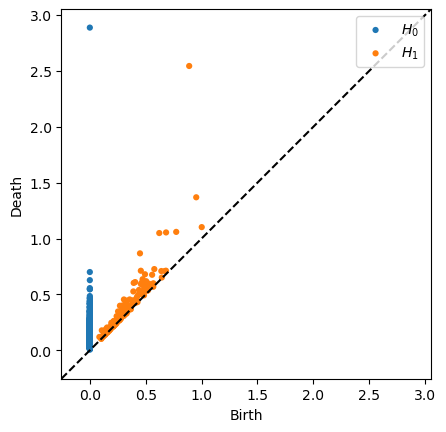

In [32]:
layout3 = umap.UMAP(
    n_components=len(high_inform),
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
).fit_transform(cluster_new_crop)
M = squareform(pdist(layout3, "euclidean"))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes

plot_diagrams(diagrams, plot_only=np.arange(maxdim + 1), show=True)
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)

cocycle = cocycles[iMax[-1]]

In [33]:
f_new, theta_matrix, verts_new, num_verts = get_coords(
    cocycle, threshold, len(layout3), M, 47, "graph", []
)
len(f_new)

number of vertices = 1007
number of edges = 143974


1007

In [34]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_new[:, 0],
            y=layout_3d_new[:, 1],
            z=layout_3d_new[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f_new,
                colorscale="Viridis",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D.html")
fig.show()

We visulize the circle using using the lucent library. For that end we calculate average activation vectors for 50 overlapping patches along the circular parameter, Then we visulize those 50 average activation vectors. 

In [42]:
buckets = 25
linsp = np.linspace(f_new.min(), f_new.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_new)):
        if linsp[a - 1] < f_new[p] < linsp[a + 1]:
            c.append(cluster_new_crop[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_new)):
    if linsp[buckets - 1] < f_new[p] or f_new[p] < linsp[1]:
        c.append(cluster_new_crop[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,), (38,)]
[15, 19, 91, 98, 66, 89, 101, 152, 151, 80, 45, 29, 35, 85, 113, 82, 34, 6, 86, 185, 139, 80, 70, 87, 74]


Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.87it/s]



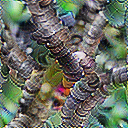

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.03it/s]



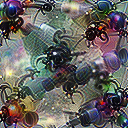

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.99it/s]



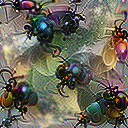

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.09it/s]



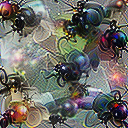

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.93it/s]



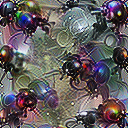

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.08it/s]



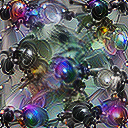

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.94it/s]



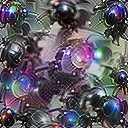

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.00it/s]



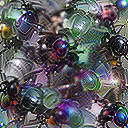

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.70it/s]



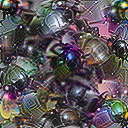

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.85it/s]



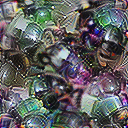

100%|█████████████████████████████████████████| 512/512 [01:10<00:00,  7.24it/s]



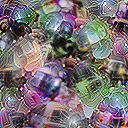

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.67it/s]



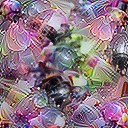

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.91it/s]



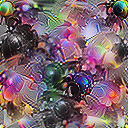

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.79it/s]



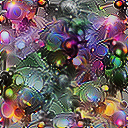

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.93it/s]



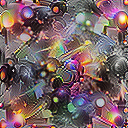

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.83it/s]



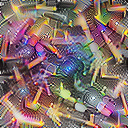

100%|█████████████████████████████████████████| 512/512 [01:33<00:00,  5.47it/s]



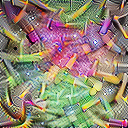

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.65it/s]



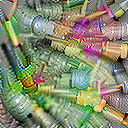

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.02it/s]



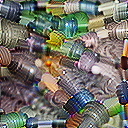

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.93it/s]



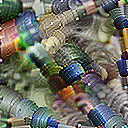

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.13it/s]



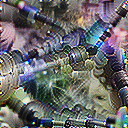

100%|█████████████████████████████████████████| 512/512 [01:00<00:00,  8.50it/s]



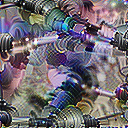

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.94it/s]



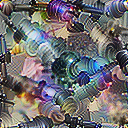

100%|█████████████████████████████████████████| 512/512 [01:15<00:00,  6.76it/s]



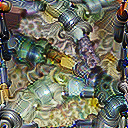

100%|█████████████████████████████████████████| 512/512 [01:07<00:00,  7.54it/s]



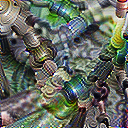

In [43]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics = []
channel = lambda n: objectives.channel("inception4e", n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics.append(d)

Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.88it/s]



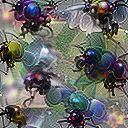

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.91it/s]



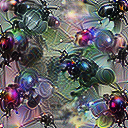

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.93it/s]



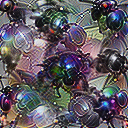

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.78it/s]



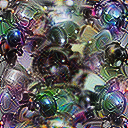

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.88it/s]



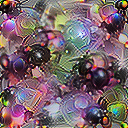

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.82it/s]



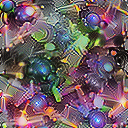

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.76it/s]



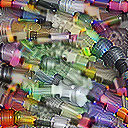

100%|█████████████████████████████████████████| 512/512 [01:07<00:00,  7.54it/s]



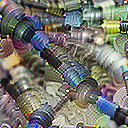

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.83it/s]



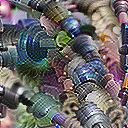

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.73it/s]



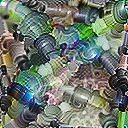

In [39]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics = []
channel = lambda n: objectives.channel("inception4e", n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics.append(d)

In [149]:
for i, im in enumerate(pics):
    np.save(f"data/circle_pics/circle_1/im_{i}.npy", im[0][0])

In [166]:
from PIL import Image

a = np.load("data/circle_pics/circle_1/im_1.npy")

a = (a * 255).astype(np.uint8)

ima = Image.fromarray(obj=a, mode="RGB")
ima.show()